In [1]:
import pykat
from pykat import finesse
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches

#import utils_DRFPMI as utl
   
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## base

s.
** Amplitude detector 'SB2p_TMSX' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB2m_TMSX' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'CR_TMSY' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB1p_TMSY' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB1m_TMSY' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB2p_TMSY' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB2m_TMSY' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'CR_POS' specified without mode indices, computing average amplitude (and dummy p

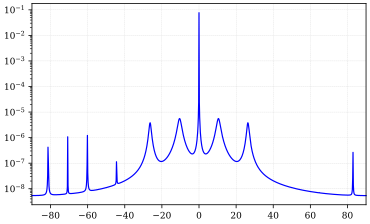

In [2]:
base =finesse.kat()
base.verbose=False

base.parse("""
    # ======== Constants ========================
    const f1 16.881M
    const f2 45.0159M
    const mf1 -16.881M
    const mf2 -45.0159M
    const a 0.686
    const pi 3.1415
    
    # ======== Input optics =====================
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 $f1 0.3 1 pm n_eo1 n_eo2
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 $f2 0.3 1 pm n_eo3 n_eo4
    s s_eo2 0 n_eo4 nREFL

    # ======= PRC each mirror loss 45ppm =======
    # PRC
    m1 PRM 0.1 45e-6 0 nREFL npr1
    s sLpr1 14.7615 npr1 npr2
    bs1 PR2 500e-6 45e-6 0 $a npr3 npr2 nPOP nPOP2
    s sLpr2 11.0661 npr3 npr4
    bs1 PR3 50e-6 45e-6 0 $a dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    # ======= Michelson ========================
    bs bs1 0.5 0.5 0 45 npr6 n2 n3 n4
    s lx 26.4018 n3 nx1		#26.6649-thickness*1.754
    s ly 23.072 n2 ny1		#23.3351-thickness*1.754


    # ======== Thick ITMs ======================
    m IXAR 0     1     0 nx1 nx2
    s thick_IX 0.15 1.754 nx2 nx3
    m ITMX 0.996 0.004 0 nx3 nx4

    m IYAR 0     1     0 ny1 ny2
    s thick_IY 0.15 1.754 ny2 ny3
    m ITMY 0.996 0.004 90 ny3 ny4

    # ========== Arm     =======================
    s sx1 3000 nx4 nx5
    m ETMX 0.999995 5e-06 0 nx5 nTMSX

    s sy1 3000 ny4 ny5
    m ETMY 0.999995 5e-06 90 ny5 nTMSY


    # ========= SRC each mirror loss 45ppm =======
    s sLsr3 15.7386 n4 nsr5
    bs1 SR3 50e-6 45e-6 0 $a nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs1 SR2 500e-6 45e-6 0 $a nsr2 nsr3 nPOS dump
    s sLsr1 14.7412 nsr2 nsr1
    m1 SRM 0.3 0e-6 0 nsr1 nAS

    # =========  HOM Expansion =======
    attr PRM Rc -458.1285
    attr PR2 Rc -3.0764
    attr PR3 Rc -24.9165
    attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    attr SRM Rc 458.1285
    attr SR2 Rc -2.9872
    attr SR3 Rc 24.9165
    attr IXAR Rc 0
    attr IYAR Rc 0
    # =========  cavity and gauss commands =======
    cav XARM ITMX nx4 ETMX nx5
    cav YARM ITMY ny4 ETMY ny5
    cav PRX PRM npr1 ITMX nx3
    cav PRY PRM npr1 ITMY ny3
    cav SRX SRM nsr1 ITMX nx3
    cav SRY SRM nsr1 ITMY ny3
    maxtem 5
    
    
    # ========  tuning =======
    pd0 pd0_DC_TMSX nTMSX #ETMx transmission
    xaxis* ETMX phi lin -90 90 1000
    yaxis lin abs
    pause 3
    trace 10
    """)
a = base.run()
print(a.rundata)

plt.figure(1)
plt.semilogy(a.x, a["pd0_DC_TMSX"])

In [9]:
# 1. Wikiに書いてある鏡間距離と曲率半径を書き込む
# FINESSEで微調整すれば少しずれることもあるが、発注する鏡はWikiに書いてあるものであり、微調整はできない。微調整は鏡の位相だけで行う。


# 2. アシンメトリなどを除去する
# まずは入射ビームのモードを腕に合わせる。
# そのために両腕のモードを揃えておく必要がある。
# 除去するのは、Schnuppアシンメトリと曲率誤差で、
# ロスインバランスは残してもよい。
# さらに、ウェッジ角と折り返し角も0度にしておく。
# この時点でミラーマップは入れない。cavコマンドは両腕のみ。

# 3. ビームパラメタを取得する(tuning1.kat)
# "trace 8"というコマンドラインを追加し、どんな計算でもいいからFINESSEを走らせると、各点でのビームプロファイルがログファイルに表示される。
# レーザーを設置した点でのプロファイルを見て、ウェスト位置とレイリーレンジを得る。
# プロファイルの向きがEOMからレーザーに向かっている場合は、ウェスト位置の符号が逆になることに注意。maxtemは5にしている。

## process 1-3

In [36]:
thickness=0.15
lx=26.6649-thickness*1.754 
ly=23.3351-thickness*1.754
print("lx=",lx,",ly=",ly)
l=(lx+ly)/2
print("l=",l)

lx= 26.401799999999998 ,ly= 23.072
l= 24.7369



** Amplitude detector 'CR_REFL' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB1p_REFL' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB1m_REFL' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB2p_REFL' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB2m_REFL' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'CR_POP' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB1p_POP' specified without mode indices, computing average amplitude (and dummy phase) over all modes.
** Amplitude detector 'SB1m_POP' specified without mode indices, computing average amplitude (and dummy phase

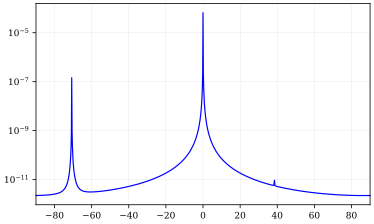

In [6]:
#Schnuppアシンメトリと曲率誤差を除去する。
#ロスインバランスは残してもよい。
#ウェッジ角と折り返し角も0度にしておく。
# この時点でミラーマップは入れない。
#n0のウェスト位置(z)とレイリーレンジ(z_R)を得る。
base_3 =finesse.kat()
base_3.verbose=False
base_3.parse('''
    # ======== Constants ========================
    const f1 16.881M
    const f2 45.0159M
    const mf1 -16.881M
    const mf2 -45.0159M
    const a 0.686
    const pi 3.1415
    
    # ======== Input optics =====================
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 $f1 0.0 1 pm n_eo1 n_eo2       #modulation index=0 
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 $f2 0.0 1 pm n_eo3 n_eo4       #modulation index=0 
    s s_eo2 0 n_eo4 nREFL

    # ======= PRC each mirror loss 45ppm =======
    # PRC
    m1 PRM 0.1 45e-6 0 nREFL npr1
    s sLpr1 14.7615 npr1 npr2
    #bs1 PR2 500e-6 45e-6 0 $a npr3 npr2 nPOP nPOP2
    bs1 PR2 0 0 0 0 npr3 npr2 nPOP nPOP2
    s sLpr2 11.0661 npr3 npr4
    #bs1 PR3 50e-6 45e-6 0 $a dump dump npr4 npr5
    bs1 PR3 0 0 0 0 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    # ======= Michelson ========================
    bs bs1 0.5 0.5 0 45 npr6 n2 n3 n4
    s lx 24.7369 n3 nx1		#(lx+ly)/2 lx=26.401799999999998
    s ly 24.7369 n2 ny1		#(lx+ly)/2 ly=23.072


    # ======== Thick ITMs ======================
    m IXAR 0     1     0 nx1 nx2
    s thick_IX 0.15 1.754 nx2 nx3
    m ITMX 0.996 0.004 0 nx3 nx4

    m IYAR 0     1     0 ny1 ny2
    s thick_IY 0.15 1.754 ny2 ny3
    m ITMY 0.996 0.004 90 ny3 ny4

    # ========== Arm     =======================
    s sx1 3000 nx4 nx5
    m ETMX 0.999995 5e-06 0 nx5 nTMSX

    s sy1 3000 ny4 ny5
    m ETMY 0.999995 5e-06 90 ny5 nTMSY


    # ========= SRC each mirror loss 45ppm =======
    s sLsr3 15.7386 n4 nsr5
    #bs1 SR3 50e-6 45e-6 0 $a nsr5 nsr4 dump dump
    bs1 SR3 50e-6 45e-6 0 $a nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    #bs1 SR2 500e-6 45e-6 0 $a nsr2 nsr3 nPOS dump
    bs1 SR2 0 0 0 $a nsr2 nsr3 nPOS dump
    s sLsr1 14.7412 nsr2 nsr1
    m1 SRM 0.3 0e-6 0 nsr1 nAS

    # =========  HOM Expansion =======
    attr PRM Rc -458.1285
    attr PR2 Rc -3.0764
    attr PR3 Rc -24.9165
    attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    attr SRM Rc 458.1285
    attr SR2 Rc -2.9872
    attr SR3 Rc 24.9165
    attr IXAR Rc 0
    attr IYAR Rc 0

    # =========  cavity and gauss commands =======
    cav XARM ITMX nx4 ETMX nx5
    cav YARM ITMY ny4 ETMY ny5
    #cav PRX PRM npr1 ITMX nx3
    #cav PRY PRM npr1 ITMY ny3
    #cav SRX SRM nsr1 ITMX nx3
    #cav SRY SRM nsr1 ITMY ny3
    maxtem 5
    
    
    
    # ======= sweep ETMX ============
    pd0 pd0_DC_TMSX nTMSX #ETMx transmission
    xaxis* ETMX phi lin -90 90 1000
    yaxis lin abs
    pause 3
    trace 10
    ''')
a_3 = base_3.run()
print(a_3.rundata)

plt.figure(1)
plt.semilogy(a_3.x, a_3["pd0_DC_TMSX"])

## process 4

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.

 --- cavity tracing
 cavity XARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  (y) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  RT Gouy: -109.246919696117 deg (mode sep.: -15.162686381772kHz)
 cavity YARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.15789

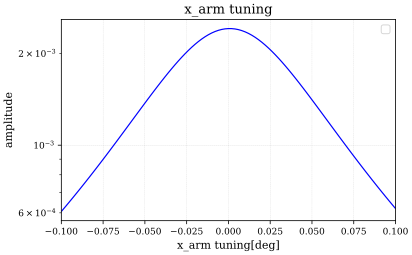

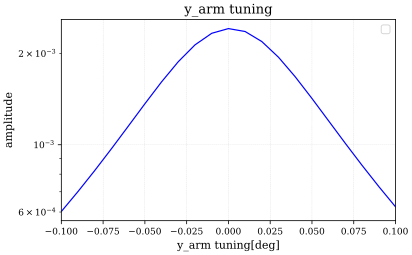

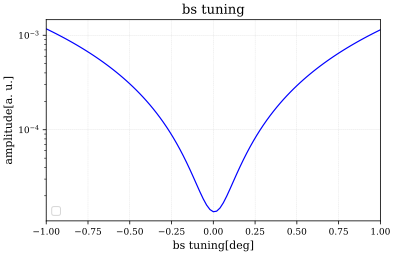

In [9]:
#　4. ミラーマップを入れて位相の調整① (tuning2.kat)
# 除去したアシンメトリや折り返し角を戻す。
# PRMとSRMの反射率をゼロにし、cavコマンドも両腕のみ。
# ミラーマップも入れて、まずはETMxとETMyの位相の調整を行う。(ITMのミラーとETMのミラーを入れた状態で、ETMを合わせる。)
# 腕の透過光が最大になるように各々の位相を合わせる。
# ETMxにのみミラーマップを入れた場合、ETMyの最適位相はゼロのはずである。
# BS の位相の調整は、SRM の透過光が最小になるようにして得る。このときETM に
# 上記の作業で得た位相を加えるのを忘れないこと。また、変調はOFF にしておく。


base_4 = finesse.kat()
base_4.verbose=False
base_4.parse("""

    # ======== Constants ========================
    const f1 16.881M
    const f2 45.0159M
    const mf1 -16.881M
    const mf2 -45.0159M
    const a 0.686
    const pi 3.1415
    
    # ======== Input optics =====================
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 $f1 0.0 1 pm n_eo1 n_eo2       #modulation index=0 
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 $f2 0.0 1 pm n_eo3 n_eo4       #modulation index=0 
    s s_eo2 0 n_eo4 nREFL

    # ======= PRC each mirror loss 45ppm =======
    # PRC
    m1 PRM 1 0 0 nREFL npr1
    s sLpr1 14.7615 npr1 npr2
    #bs1 PR2 500e-6 45e-6 0 $a npr3 npr2 nPOP nPOP2
    bs1 PR2 0 0 0 $a npr3 npr2 nPOP nPOP2
    s sLpr2 11.0661 npr3 npr4
    #bs1 PR3 50e-6 45e-6 0 $a dump dump npr4 npr5
    bs1 PR3 0 0 0 $a dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    # ======= Michelson ========================
    #bs bs1 0.5 0.5 0 45 npr6 n2 n3 n4
    bs bs1 0.5 0.5 0.33 45.0 npr6 n2 n3 n4 #after tuning #0.25ずれていて、0.25に設定して動かしたら0.03ずれている表示がされた。→(0.25+0.03)で設定。ずれが発生する。(繰り返して位相を足していき合わせた)
    s lx 26.401799999999998 n3 nx1
    s ly 23.072 n2 ny1


    # ======== Thick ITMs ======================
    m IXAR 0     1     0 nx1 nx2
    s thick_IX 0.15 1.754 nx2 nx3
    m ITMX 0.996 0.004 0 nx3 nx4

    m IYAR 0     1     0 ny1 ny2
    s thick_IY 0.15 1.754 ny2 ny3
    m ITMY 0.996 0.004 90 ny3 ny4

    # ========== Arm     =======================
    s sx1 3000 nx4 nx5
    #m ETMX 0.999995 5e-06 0. nx5 nTMSX
    m ETMX 0.99995 5e-06 0.025 nx5 nTMSX #after tuning
    

    s sy1 3000 ny4 ny5
    #m ETMY 0.999995 5e-06 90 ny5 nTMSY
    m ETMY 0.99995 5e-06 90.025 ny5 nTMSY    #after tuning
    

    # ========= SRC each mirror loss 45ppm =======
    s sLsr3 15.7386 n4 nsr5
    #bs1 SR3 50e-6 45e-6 0 $a nsr5 nsr4 dump dump
    bs1 SR3 50e-6 45e-6 0 $a nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    #bs1 SR2 500e-6 45e-6 0 $a nsr2 nsr3 nPOS dump
    bs1 SR2 0 0 0 $a nsr2 nsr3 nPOS dump
    s sLsr1 14.7412 nsr2 nsr1
    m1 SRM 1 0 0 nsr1 nAS

    # =========  HOM Expansion =======
    attr PRM Rc -458.1285
    attr PR2 Rc -3.0764
    attr PR3 Rc -24.9165
    attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    attr SRM Rc 458.1285
    attr SR2 Rc -2.9872
    attr SR3 Rc 24.9165
    attr IXAR Rc 0
    attr IYAR Rc 0

    # =========  cavity and gauss commands =======
    cav XARM ITMX nx4 ETMX nx5
    cav YARM ITMY ny4 ETMY ny5
    #cav PRX PRM npr1 ITMX nx3
    #cav PRY PRM npr1 ITMY ny3
    #cav SRX SRM nsr1 ITMX nx3
    #cav SRY SRM nsr1 ITMY ny3
    maxtem 5
    gauss* input i1 n0 -7.52069352993567 57.7078536063058
    
""")
base_4_x = base_4.deepcopy()
base_4_x.parse("""
    # =========  x-arm mirror map =======
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    pd0 pd0_DC_TMSX nTMSX
    ### tuning x-arm
    xaxis* ETMX phi lin -0.1 0.1 100
    yaxis lin abs
    pause 3
    trace 2
   
    """)

base_4_y = base_4.deepcopy()
base_4_y.parse("""
    
    # =========  y-arm mirror map =======
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    pd0 pd0_DC_TMSY nTMSY
    ### tuning y-arm
    xaxis* ETMY phi lin -0.1 0.1 20
    yaxis lin abs
    pause 3
    trace 2
   
    
    """)
base_4_bs = base_4.deepcopy()
base_4_bs.parse("""
    # =========  x-arm mirror map =======
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    # =========  y-arm mirror map =======
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    # ======== tuning BS =========
    pd0 pd0_DC_AS nAS
    variable dphi 1
    xaxis dphi abs lin -1 1 100
    put* ETMX phi $x1
    put* ITMX phi $x1
    put* ETMY phi $mx1
    put* ITMY phi $mx1
    phase 3
    trace 2
    """)

a_4_x = base_4_x.run()
a_4_y = base_4_y.run()
a_4_bs = base_4_bs.run()
print(a_4_x.rundata)
print(a_4_y.rundata)
print(a_4_bs.rundata)
plt.figure(1)
plt.semilogy(a_4_x.x, a_4_x["pd0_DC_TMSX"])
plt.title('x_arm tuning')
plt.legend(loc=1)
plt.xlabel("x_arm tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_4_y.x, a_4_y["pd0_DC_TMSY"])
plt.title('y_arm tuning')
plt.legend(loc=1)
plt.xlabel("y_arm tuning[deg]")
plt.ylabel("amplitude")

plt.figure(3)
plt.semilogy(a_4_bs.x, a_4_bs["pd0_DC_AS"])
plt.title('bs tuning')
plt.legend(loc=1)
plt.xlabel("bs tuning[deg]")
plt.ylabel("amplitude[a. u.]")
plt.legend()

## process 5


 --- cavity tracing
 cavity XARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  (y) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  RT Gouy: -109.246919696117 deg (mode sep.: -15.162686381772kHz)
 cavity YARM:
  cavity is stable! Eigenvalues:
  q=-1500+774.597j, w0=16.1969667343171mm z=-1.5km m=-0.32964
  finesse : 1548.34, round-trip power loss: 0.0040498 [/100]
  opt. length: 6km, FSR: 49.9654096666667kHz, m: -329.639889196676m
  FWHM: 32.2703889304753Hz (pole: 16.1351944652377Hz)
  (x) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  (y) A: -2.1578947 B: -3473.6842 C: 0.0012188366 D: 1.498615
  RT Gouy: -109.246919696117 deg (mode sep.: -15.162686381772kHz)
 cavity PRX:
  

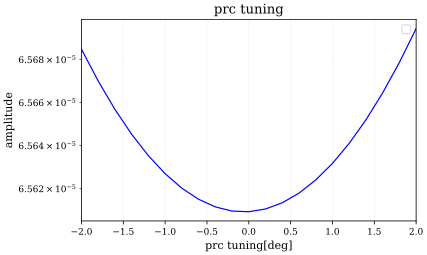

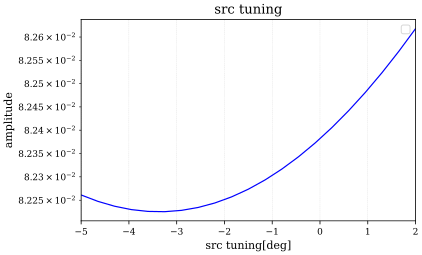

In [26]:
# 5. ミラーマップを入れて位相の調整② (tuning3.kat)
# PRMとSRMの反射率を元に戻し、PRCとSRCのcavコマンドを入れる。
# まず腕の透過光が最大になるようにPRMの位相を調整し、
# 次にadを用いて、腕を差動に振って生成した10kHzの信号が最大になるようにSRMの位相を調整する。
# このときの干渉計構成は、Broadband RSEであると考えられる。
# SRMの位相をこの状態からさらに3.5度ずらせばKAGRAが目指すDetuned RSEとなる。


base_5 = finesse.kat()
base_5.verbose=False
base_5.parse("""


    # ======== Constants ========================
    const f1 16.881M
    const f2 45.0159M
    const mf1 -16.881M
    const mf2 -45.0159M
    const a 0.686
    const pi 3.1415
    
    # ======== Input optics =====================
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 $f1 0.0 1 pm n_eo1 n_eo2       #modulation index=0 
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 $f2 0.0 1 pm n_eo3 n_eo4       #modulation index=0 
    s s_eo2 0 n_eo4 nREFL

    # ======= PRC each mirror loss 45ppm =======
    # PRC
    m1 PRM 0.1 45e-6 -0.75 nREFL npr1   #after tuning
    #m1 PRM 0.1 45e-6 0.0 nREFL npr1    #Add transmittance and reflectance
    s sLpr1 14.7615 npr1 npr2
    bs1 PR2 0 0 0 $a npr3 npr2 nPOP nPOP2   #折り返し角のみ追加
    s sLpr2 11.0661 npr3 npr4
    bs1 PR3 0 0 0 $a dump dump npr4 npr5    #折り返し角のみ追加
    s sLpr3 15.7638 npr5 npr6

    # ======= Michelson ========================
    bs bs1 0.5 0.5 0.33 45.0 npr6 n2 n3 n4
    s lx 26.401799999999998 n3 nx1
    s ly 23.072 n2 ny1

    # ======== Thick ITMs ======================
    m IXAR 0     1     0 nx1 nx2
    s thick_IX 0.15 1.754 nx2 nx3
    m ITMX 0.996 0.004 0 nx3 nx4

    m IYAR 0     1     0 ny1 ny2
    s thick_IY 0.15 1.754 ny2 ny3
    m ITMY 0.996 0.004 90 ny3 ny4

    # ========== Arm     =======================
    s sx1 3000 nx4 nx5
    #m ETMX 0.999995 5e-06 0. nx5 nTMSX
    m ETMX 0.99995 5e-06 0.025 nx5 nTMSX #after tuning
    

    s sy1 3000 ny4 ny5
    #m ETMY 0.999995 5e-06 90 ny5 nTMSY
    m ETMY 0.99995 5e-06 90.025 ny5 nTMSY    #after tuning
    

    # ========= SRC each mirror loss 45ppm =======
    s sLsr3 15.7386 n4 nsr5
    bs1 SR3 0 0 0 $a nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs1 SR2 0 0 0 $a nsr2 nsr3 nPOS dump
    s sLsr1 14.7412 nsr2 nsr1
    #m1 SRM 0.3 0e-6 0 nsr1 nAS
    m1 SRM 0.3 0e-6 4.50 nsr1 nAS   #after tuning(x+3.5) x=1.0

    # =========  HOM Expansion =======
    attr PRM Rc -458.1285
    attr PR2 Rc -3.0764
    attr PR3 Rc -24.9165
    attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    attr SRM Rc 458.1285
    attr SR2 Rc -2.9872
    attr SR3 Rc 24.9165
    attr IXAR Rc 0
    attr IYAR Rc 0
    
    # =========  cavity and gauss commands =======
    cav XARM ITMX nx4 ETMX nx5
    cav YARM ITMY ny4 ETMY ny5
    cav PRX PRM npr1 ITMX nx3
    #cav PRY PRM npr1 ITMY ny3
    #cav SRX SRM nsr1 ITMX nx3
    cav SRY SRM nsr1 ITMY ny3
    maxtem 5
    gauss* input i1 n0 -7.52069352993567 57.7078536063058
    
    # =========  x-arm mirror map =======
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    # =========  y-arm mirror map =======
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    
    """)

base_5_prc = base_5.deepcopy()
base_5_prc.parse("""
    # ======= tuning PRC =============
    pd0 pd0_DC_TMSX nTMSX
    xaxis* PRM phi lin -2 2 20
    yaxis lin abs
    pause 3
    trace 2
""")
base_5_src = base_5.deepcopy()
base_5_src.parse("""
    # ======= tuning SRC =============    
    pd0 pd0_DC_TMSX nTMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k nAS
    xaxis* SRM phi lin -5 2 20 
    yaxis lin abs
    pause 3
    trace 2
    
""")
a_5_p = base_5_prc.run()
a_5_s = base_5_src.run()
print(a_5_p.rundata)
print(a_5_s.rundata)

plt.figure(1)
plt.semilogy(a_5_p.x, a_5_p["pd0_DC_TMSX"])
plt.title('prc tuning')
plt.legend(loc=1)
plt.xlabel("prc tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_5_s.x, a_5_s["pd"])
plt.title('src tuning')
plt.legend(loc=1)
plt.xlabel("src tuning[deg]")
plt.ylabel("amplitude")

plt.legend()

### Add transmittance and reflectance for PRC and SRC

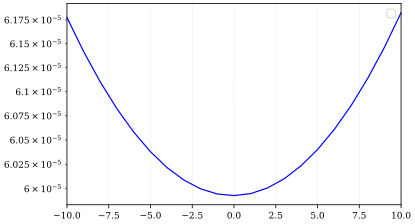

In [38]:
base_5_tr = finesse.kat()
base_5_tr.verbose=False
base_5_tr.parse("""
    

    # ======== Constants ========================
    const f1 16.881M
    const f2 45.0159M
    const mf1 -16.881M
    const mf2 -45.0159M
    const a 0.686
    const pi 3.1415
    
    # ======== Input optics =====================
    l i1 1 0 n0
    s s_eo0 0 n0 n_eo1
    mod eom1 $f1 0.0 1 pm n_eo1 n_eo2       #modulation index=0 
    s s_eo1 0 n_eo2 n_eo3
    mod eom2 $f2 0.0 1 pm n_eo3 n_eo4       #modulation index=0 
    s s_eo2 0 n_eo4 nREFL

    # ======= PRC each mirror loss 45ppm =======
    # PRC
    m1 PRM 0.1 45e-6 -0.75 nREFL npr1 
    #m1 PRM 0.1 45e-6 0.0 nREFL npr1
    s sLpr1 14.7615 npr1 npr2
    bs1 PR2 500e-6 45e-6 0 $a npr3 npr2 nPOP nPOP2  #Add transmittance and reflectance
    s sLpr2 11.0661 npr3 npr4
    bs1 PR3 50e-6 45e-6 0 $a dump dump npr4 npr5 #Add transmittance and reflectance
    s sLpr3 15.7638 npr5 npr6

    # ======= Michelson ========================
    bs bs1 0.5 0.5 0.33 45.0 npr6 n2 n3 n4
    s lx 26.401799999999998 n3 nx1 
    s ly 23.072 n2 ny1


    # ======== Thick ITMs ======================
    m IXAR 0     1     0 nx1 nx2
    s thick_IX 0.15 1.754 nx2 nx3
    m ITMX 0.996 0.004 0 nx3 nx4

    m IYAR 0     1     0 ny1 ny2
    s thick_IY 0.15 1.754 ny2 ny3
    m ITMY 0.996 0.004 90 ny3 ny4

    # ========== Arm     =======================
    s sx1 3000 nx4 nx5
    m ETMX 0.99995 5e-06 0.025 nx5 nTMSX
    

    s sy1 3000 ny4 ny5
    m ETMY 0.99995 5e-06 90.025 ny5 nTMSY
    

    # ========= SRC each mirror loss 45ppm =======
    s sLsr3 15.7386 n4 nsr5
    bs1 SR3 50e-6 45e-6 0 $a nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs1 SR2 500e-6 45e-6 0 $a nsr2 nsr3 nPOS dump
    s sLsr1 14.7412 nsr2 nsr1
    #m1 SRM 0.3 0e-6 0 nsr1 nAS
    m1 SRM 0.3 0e-6 4.50 nsr1 nAS

    # =========  HOM Expansion =======
    attr PRM Rc -458.1285
    attr PR2 Rc -3.0764
    attr PR3 Rc -24.9165
    attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    attr SRM Rc 458.1285
    attr SR2 Rc -2.9872
    attr SR3 Rc 24.9165
    attr IXAR Rc 0
    attr IYAR Rc 0
    
    # =========  cavity and gauss commands =======
    cav XARM ITMX nx4 ETMX nx5
    cav YARM ITMY ny4 ETMY ny5
    cav PRX PRM npr1 ITMX nx3
    #cav PRY PRM npr1 ITMY ny3
    #cav SRX SRM nsr1 ITMX nx3
    cav SRY SRM nsr1 ITMY ny3
    gauss* input i1 n0 -7.52069352993567 57.7078536063058
    maxtem 5
    
    # =========  x-arm mirror map =======
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI4
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI4
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    # =========  y-arm mirror map =======
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI4
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI4
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    # ========= tuning PRC ==========
    pd0 pd0_DC_TMSX nTMSX
    xaxis* PRM phi lin -10 10 20
    yaxis lin abs
    pause 3
    trace 2

""")
a_5_tr = base_5_tr.run()

plt.figure(1)
plt.semilogy(a_5_tr.x, a_5_tr["pd0_DC_TMSX"])
plt.legend()